In [4]:
#!/usr/bin/env python3
#in this script we will extract fibroblast cells in the panfetal atlas dataset

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [5]:
adata = ad.read_h5ad("/g/data/yr31/hb1618/iPSC_project/datasets/panfetal_whole/panfetal_whole.h5ad")

In [6]:
print(adata)

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [7]:
#first we will subset out the cell type of interest
cell_types_to_keep = ["FIBROBLAST_I"]
adata = adata[adata.obs['celltype_annotation'].isin(cell_types_to_keep)].copy() 

In [8]:
print(adata)

AnnData object with n_obs × n_vars = 25041 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [9]:
#examine the donor metadata
adata.obs["donor"]

FCAImmP7579224-ACGGCCATCTCCAGGG    F45
FCAImmP7579224-ACGATGTCACAGACAG    F45
FCAImmP7579224-TTAACTCGTTAAGAAC    F45
FCAImmP7579224-CTCGGAGCAGTCGATT    F45
FCAImmP7579224-GAAGCAGAGTTAGGTA    F45
                                  ... 
FCAImmP7803042-CATTCGCGTCGGATCC    F51
FCAImmP7803042-TAAGAGAGTCGTCTTC    F51
FCAImmP7803042-CTCATTAAGGAGTTGC    F51
FCAImmP7803042-TCACAAGAGCGTCAAG    F51
FCAImmP7803042-CGTAGCGAGTGACATA    F51
Name: donor, Length: 25041, dtype: category
Categories (25, object): ['F19', 'F21', 'F22', 'F23', ..., 'F71', 'F72', 'F73', 'F78']

In [10]:
#performing quality control
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [11]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

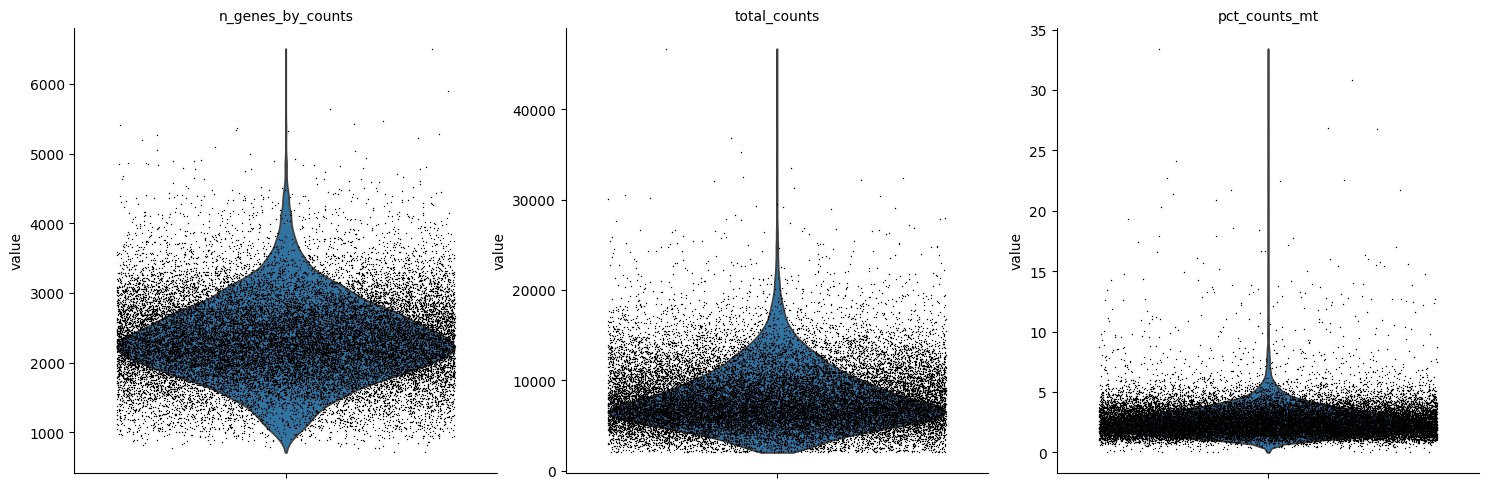

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

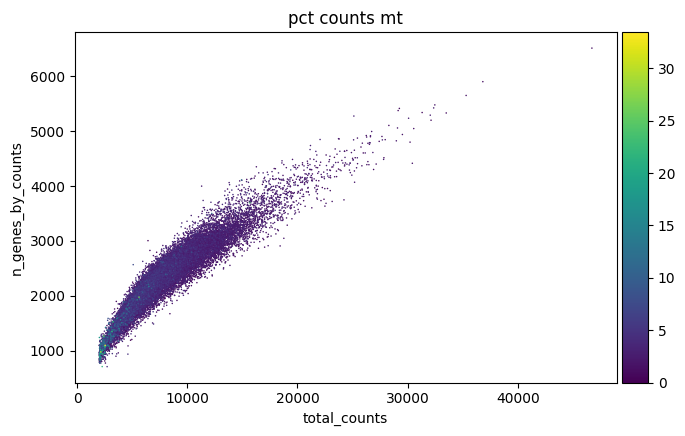

In [13]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [14]:
#it seems that QC has already been applied to the above cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 10].copy()

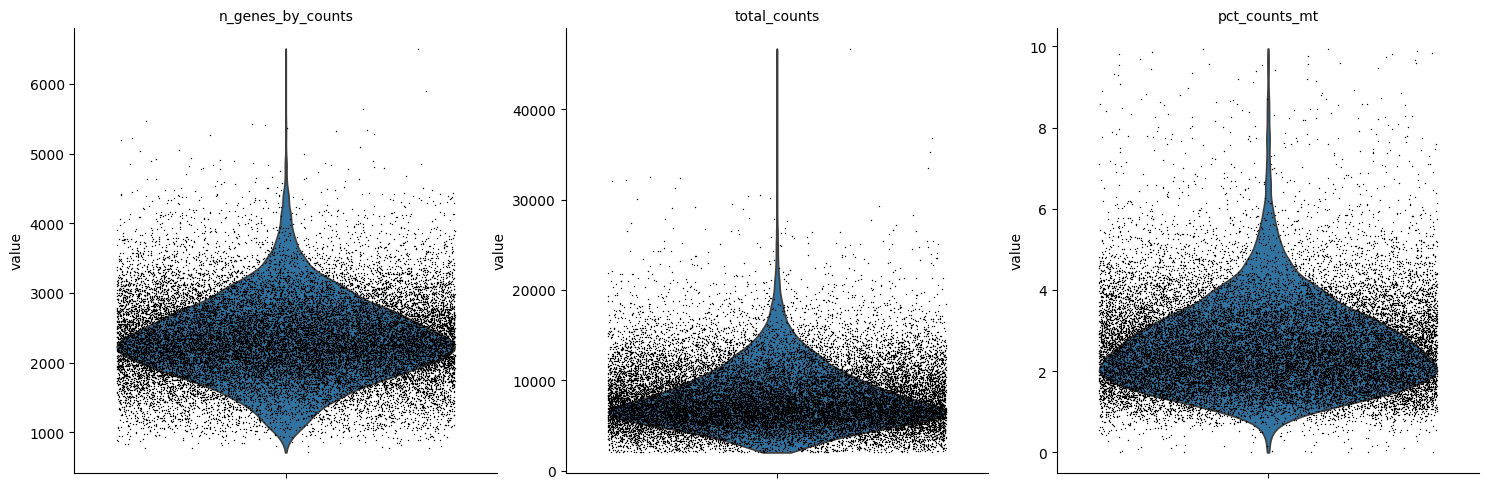

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [16]:
adata.obs['predicted_doublets'].value_counts()

predicted_doublets
False    24870
True        37
Name: count, dtype: int64

In [17]:
adata = adata[adata.obs['predicted_doublets'] == 'False'].copy()

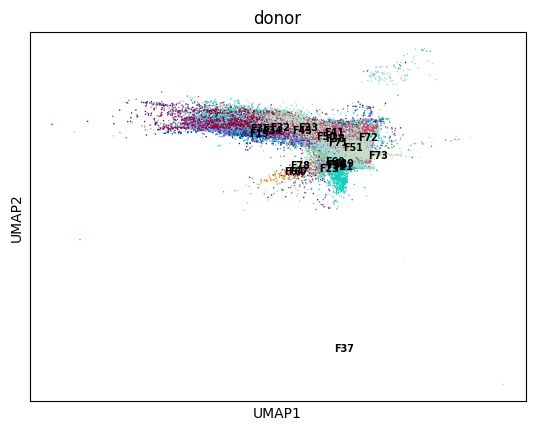

In [18]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')

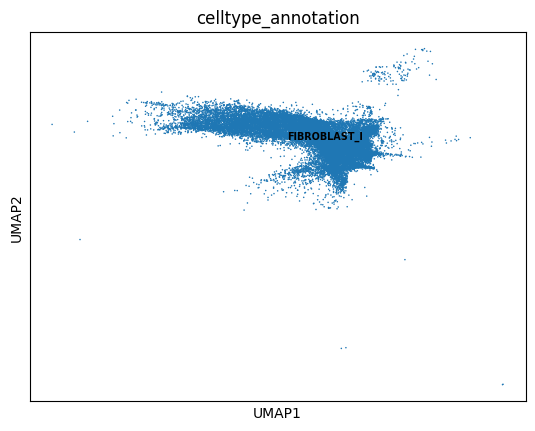

In [19]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

In [20]:
adata.obs['donor'].value_counts()

donor
F71    4836
F51    3068
F34    2972
F50    2908
F32    2075
F69    2052
F38    1608
F45    1170
F41    1075
F33    1030
F19     875
F35     729
F67     146
F21     106
F30      80
F73      36
F66      34
F23      23
F29      18
F64      17
F72       7
F78       3
F37       2
Name: count, dtype: int64

In [21]:
# In order to get 3-5 donors, and ~5000 cells, we will select donors F32, F38, F41, F33
donors_to_keep = ["F32", "F38", "F33", "F41"]
adata = adata[adata.obs['donor'].isin(donors_to_keep)].copy() 

In [22]:
print(adata)

AnnData object with n_obs × n_vars = 5788 × 22496
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 's

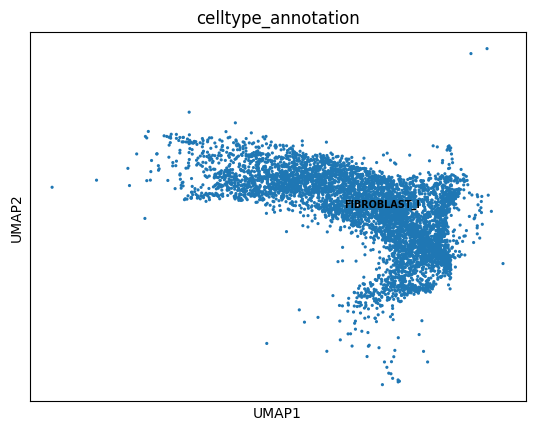

In [23]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

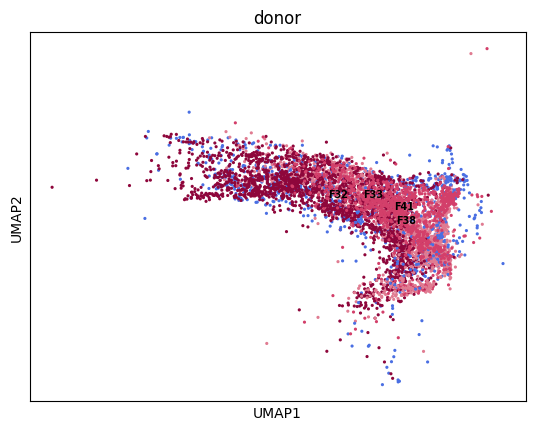

In [24]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')

In [25]:
#exporting extracted data
#exporting count data

# Convert to DataFrame with cells as rows, genes as columns
count_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

In [26]:
# Save the DataFrame to a .tsv file
count_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/multi_benchmark/fibroblast/fibroblast_countdata.tsv", sep='\t')

In [27]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/multi_benchmark/fibroblast/fibroblast_metadata.csv")